In [53]:
import torch
from transformers import BertModel, BertTokenizerFast
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from tools import DatasetProvider, EvaluateTools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
model_name = "dbmdz/bert-base-german-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
base_model = BertModel.from_pretrained(model_name)

for param in base_model.parameters():
    param.requires_grad = False

In [55]:
def train_encodings(X_train, X_test, y_train, y_test):
    train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors="pt")
    test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors="pt")

    train_labels = torch.tensor(y_train, dtype=torch.long)
    test_labels = torch.tensor(y_test, dtype=torch.long)

    class TextDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels
        
        def __getitem__(self, idx):
            item = {key: val[idx] for key, val in self.encodings.items()}
            item['labels'] = self.labels[idx]
            return item
        
        def __len__(self):
            return len(self.labels)

    train_dataset = TextDataset(train_encodings, train_labels)
    test_dataset = TextDataset(test_encodings, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    return train_loader, test_loader

In [56]:
class CustomBertClassifier(nn.Module):
    def __init__(self, base_model, num_labels=2, hidden_size=768):
        super(CustomBertClassifier, self).__init__()
        self.bert = base_model
        self.classifier = nn.Linear(hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad():
            # Pass through BERT to get embeddings, no gradient
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the [CLS] token's representation
        cls_output = outputs.last_hidden_state[:,0,:]  # shape: (batch_size, hidden_size)
        
        # Apply classification layer
        logits = self.classifier(cls_output)  # shape: (batch_size, num_labels)
        
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        
        return loss, logits

In [57]:
num_labels = 2
model = CustomBertClassifier(base_model, num_labels=num_labels)

# only update the classification layer's parameters
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomBertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [58]:
def infer_batch(batch):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    loss, logits = model(input_ids, attention_mask, labels=labels)

    return loss, logits

In [59]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            loss, logits = infer_batch(batch)
            
            test_loss += loss.item()
    
    return test_loss / len(test_loader)

In [60]:
def train_model(train_loader, test_loader, num_epochs = 3):
    model.train()
    training_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        epoch_training_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            optimizer.zero_grad()

            loss, logits = infer_batch(batch)
            
            loss.backward()
            optimizer.step()
            
            epoch_training_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        # Average training loss for the epoch
        training_losses.append(epoch_training_loss / len(train_loader))

        # Evaluate on the test set
        test_loss = evaluate_model(model, test_loader)
        test_losses.append(test_loss)

    return training_losses, test_losses

In [61]:
def plot_training_curves(num_epochs, training_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Test Loss')
    plt.legend()
    plt.show()

In [62]:
def get_predictions(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            loss, logits = model(input_ids, attention_mask, labels=None)
            preds = torch.argmax(logits, dim=-1).cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)
    
    return predictions, true_labels

# Training on Germ Eval 18

In [63]:
dataset_name="philschmid/germeval18"
dataset_germeval = DatasetProvider.get_germ_eval_18(dataset_name)
DatasetProvider.stats(dataset_germeval)

Sample Data:
{'text': '@corinnamilborn Liebe Corinna, wir würden dich gerne als Moderatorin für uns gewinnen! Wärst du begeisterbar?', 'label': 0}

Data Length:
8407
Number of labels with 1: 2838
Number of labels with 0: 5569


In [64]:
X_train, X_test, y_train, y_test = DatasetProvider.split_data(dataset_germeval)

Training samples: 6725, Test samples: 1682


In [65]:
train_loader, test_loader = train_encodings(X_train, X_test, y_train, y_test)

In [66]:
num_epochs = 250
training_losses, test_losses = train_model(train_loader, test_loader, num_epochs=num_epochs)

Epoch 145/250:  24%|██▎       | 99/421 [00:20<01:05,  4.93it/s, loss=0.447]


KeyboardInterrupt: 

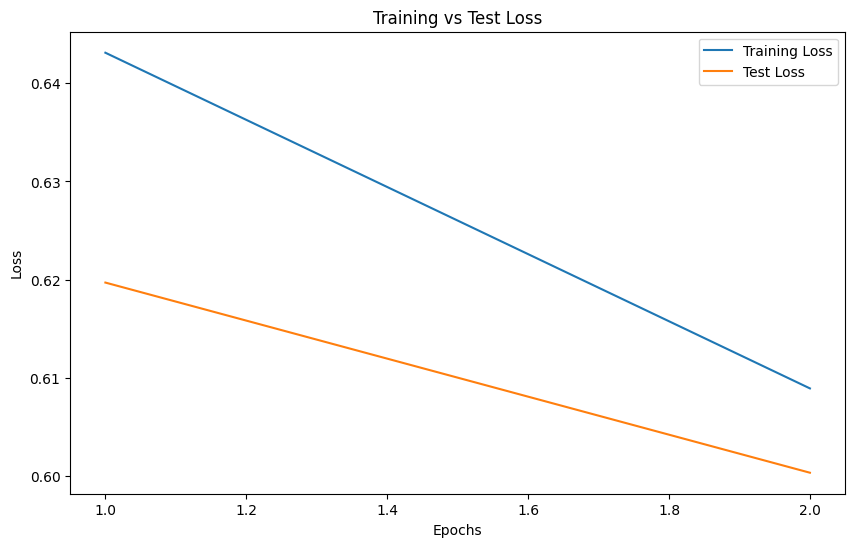

In [51]:
plot_training_curves(num_epochs, training_losses, test_losses)

Model Evaluation Metrics:
Accuracy: 0.6677
Precision: 0.0634
Recall: 0.5714
F1 Score: 0.1141


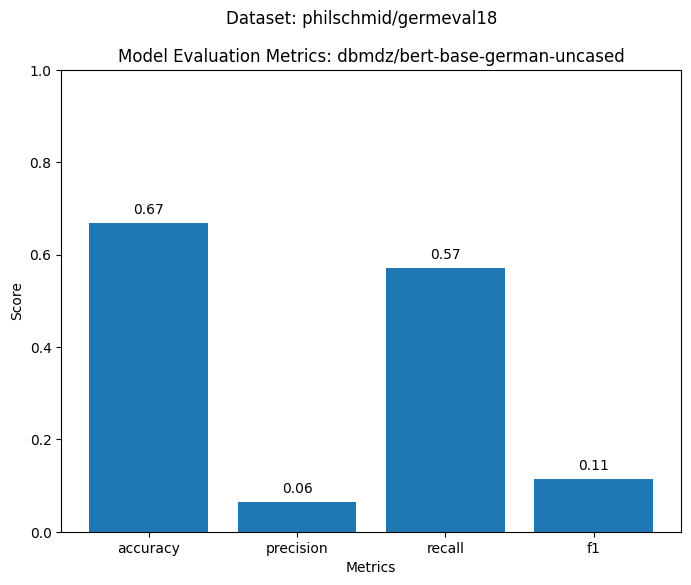

In [52]:
true_labels, predictions = get_predictions(model, test_loader)
metrics = EvaluateTools.calc_metrics(true_labels, predictions)
EvaluateTools.plot_metrics(metrics, model_name + ' my custom classification', dataset_name)

# Training on german superset

In [ ]:
dataset_name = "manueltonneau/german-hate-speech-superset"
dataset_superset = DatasetProvider.get_superset(dataset_name)
DatasetProvider.stats(dataset_superset)

Sample Data:
{'text': '@corinnamilborn Liebe Corinna, wir würden dich gerne als Moderatorin für uns gewinnen! Wärst du begeisterbar?', 'label': 0}

Data Length:
8407
Number of labels with 1: 2838
Number of labels with 0: 5569


In [ ]:
X_train, X_test, y_train, y_test = DatasetProvider.split_data(dataset_superset)

Training samples: 6725, Test samples: 1682


In [ ]:
train_loader, test_loader = train_encodings(X_train, X_test, y_train, y_test)

In [ ]:
num_epochs = 250
training_losses, test_losses = train_model(train_loader, test_loader, num_epochs=num_epochs)

Epoch 2/2: 100%|██████████| 421/421 [01:22<00:00,  5.12it/s, loss=0.522]


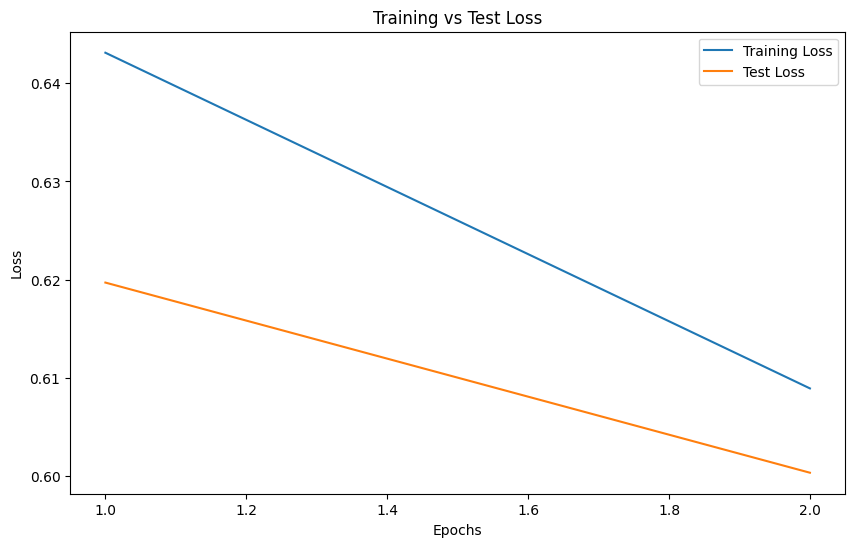

In [ ]:
plot_training_curves(num_epochs, training_losses, test_losses)

Model Evaluation Metrics:
Accuracy: 0.6677
Precision: 0.0634
Recall: 0.5714
F1 Score: 0.1141


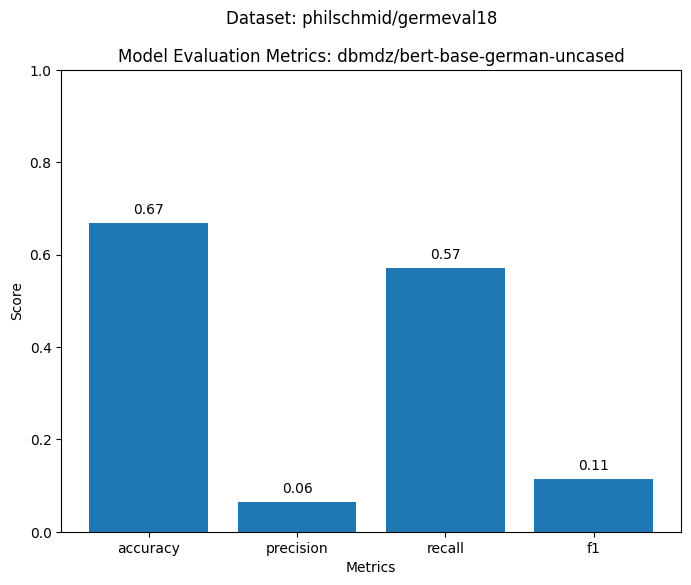

In [ ]:
true_labels, predictions = get_predictions(model, test_loader)
metrics = EvaluateTools.calc_metrics(true_labels, predictions)
EvaluateTools.plot_metrics(metrics, model_name + ' my custom classification', dataset_name)